In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, beta

In [13]:
class Trail():
    def __init__(self, length, num_obstacles, wvl_dists, amp_dists, loc_dists, probs=None, delta_t=0.01, equilibrium_force=0):
        self.length = length
        self.num_obstacles = num_obstacles
        
        assert len(wvl_dists) == len(amp_dists) == len(loc_dists), "parameter distributions must be lists of equal length"
        self.wvl_dists = wvl_dists
        self.amp_dists = amp_dists
        self.loc_dists = loc_dists
        
        if probs is None:
            self.probs = [1/len(wvl_dists) for _ in range(len(wvl_dists))]
        else:
            assert np.isclose(1, sum(probs)), "probabilities must sum to 1"
            
        self.timesteps = np.linspace(0, self.length, int(self.length / delta_t + 1))
        self.trail = None
        self.obstacles = []

        trail = equilibrium_force * np.ones_like(self.timesteps)
        wvls = np.empty(self.num_obstacles)
        amps = np.empty(self.num_obstacles)
        locs = np.empty(self.num_obstacles)
        for i in range(self.num_obstacles):
            j = np.random.choice(np.arange(len(self.wvl_dists)), p=probs)
            wvls[i] = self.wvl_dists[j].rvs()
            amps[i] = self.amp_dists[j].rvs()
            locs[i] = self.loc_dists[j].rvs()
            obstacle = Obstacle(wvls[i], amps[i], locs[i])
            self.obstacles.append(obstacle)
            trail += np.array([obstacle.force(t) for t in self.timesteps])
        self.trail = trail
    
    def plot_trail(self):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
        ax.plot(self.timesteps, self.trail)
        ax.set_xlim(0, self.length)
        ax.set_ylim(0, max(self.trail))
        plt.show()

    def get_trail(self):
        return self.trail

In [25]:
class OldObstacle():
    def __init__(self, wvl, amp, loc, shape=None):
        self.wvl = wvl
        self.amp = amp
        self.loc = loc
        
        if shape is None:
            self.shape = np.random.randint(6)
        else:
            self.shape = shape
            
        self.freq = np.pi / self.wvl
        
        if self.shape == 0:
            self.force = lambda t: self.amp * np.sin(self.freq*(t-self.loc)) if self.loc <= t <= self.loc + self.wvl else 0
        elif self.shape == 1:
            self.force = lambda t: self.amp * np.sin(self.freq*(t-self.loc)) if self.loc <= t <= self.loc + self.wvl / 2 else 0
        elif self.shape == 2:
            self.force = lambda t: self.amp * np.sin(self.freq*(t-self.loc)) if self.loc + self.wvl / 2 <= t <= self.loc + self.wvl else 0
        elif self.shape == 3:
            self.force = lambda t: self.amp - self.amp * np.sin(self.freq*(t-self.loc)) if self.loc <= t <= self.loc + self.wvl else 0
        elif self.shape == 4:
            self.force = lambda t: self.amp - self.amp * np.sin(self.freq*(t-self.loc)) if self.loc <= t <= self.loc + self.wvl / 2 else 0
        elif self.shape == 5:
            self.force = lambda t: self.amp - self.amp * np.sin(self.freq*(t-self.loc)) if self.loc + self.wvl / 2 <= t <= self.loc + self.wvl else 0
        else:
            raise ValueError("shape must be an integer between 0 and 4 inclusive")
        
    def plot_force(self, res=500):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
        domain = np.linspace(0, self.loc+self.wvl, res)
        forces = [self.force(t) for t in domain]
        ax.plot(domain, forces)
        ax.set_xlim(0, self.loc+self.wvl)
        ax.set_ylim(0, max(forces))
        ax.set_xlabel("time (seconds)")
        ax.set_ylabel("force (newtons)")
        ax.set_title("Obstacle Force")
        plt.show()

In [47]:
class Obstacle():
    def __init__(self, wvl, amp, loc, shape=None):
        self.wvl = wvl
        self.amp = amp
        self.loc = loc
        
        if shape is None:
            self.shape = np.random.randint(4)
        else:
            self.shape = shape
            
        if self.shape == 0:
            self.force = lambda t: self.amp - self.amp*(2*((t-self.loc)/self.wvl - 0.5))**4 if self.loc <= t <= self.loc + self.wvl else 0
        elif self.shape == 1:
            self.force = lambda t: -432*self.amp*((t-self.loc)/self.wvl)*(((t-self.loc)/self.wvl - 0.5)**4)*((t-self.loc)/self.wvl - 1) if self.loc <= t <= self.loc + self.wvl else 0
        elif self.shape == 2:
            self.force = lambda t: -432*self.amp*((t-self.loc)/self.wvl)*(((t-self.loc)/self.wvl - 0.5)**4)*((t-self.loc)/self.wvl - 1) if self.loc <= t <= self.loc + self.wvl / 2 else 0
        elif self.shape == 3:
            self.force = lambda t: -432*self.amp*((t-self.loc)/self.wvl)*(((t-self.loc)/self.wvl - 0.5)**4)*((t-self.loc)/self.wvl - 1) if self.loc + self.wvl / 2 <= t <= self.loc + self.wvl else 0
        else:
            raise ValueError("shape must be an integer between 0 and 5 inclusive")
        
    def plot_force(self, res=500):
        
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
        domain = np.linspace(0, self.loc+self.wvl, res)
        forces = [self.force(t) for t in domain]
        ax.plot(domain, forces)
        ax.set_xlim(0, self.loc+self.wvl)
        ax.set_ylim(0, max(forces))
        ax.set_xlabel("time (seconds)")
        ax.set_ylabel("force (newtons)")
        ax.set_title("Obstacle Force")
        plt.show()

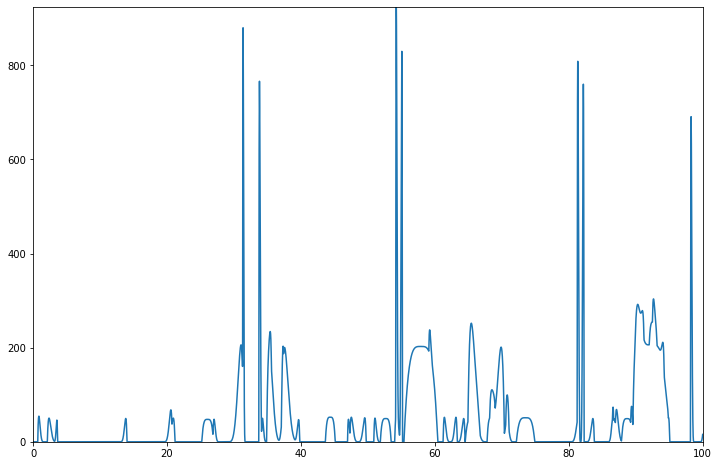

In [51]:
LENGTH = 100
wvl_dists = [norm(loc=1, scale=0.1), norm(loc=2, scale=0.4), norm(loc=5, scale=0.4)]
amp_dists = [norm(loc=800, scale=50), norm(loc=50, scale=2), norm(loc=200, scale=4)]
loc_dists = [uniform(loc=0, scale=LENGTH), uniform(loc=0, scale=LENGTH), uniform(loc=0, scale=LENGTH)]
probs = [0.1, 0.75, 0.15]
trail = Trail(length=LENGTH, num_obstacles=50, wvl_dists=wvl_dists, amp_dists=amp_dists, loc_dists=loc_dists, probs=probs)
trail.plot_trail()

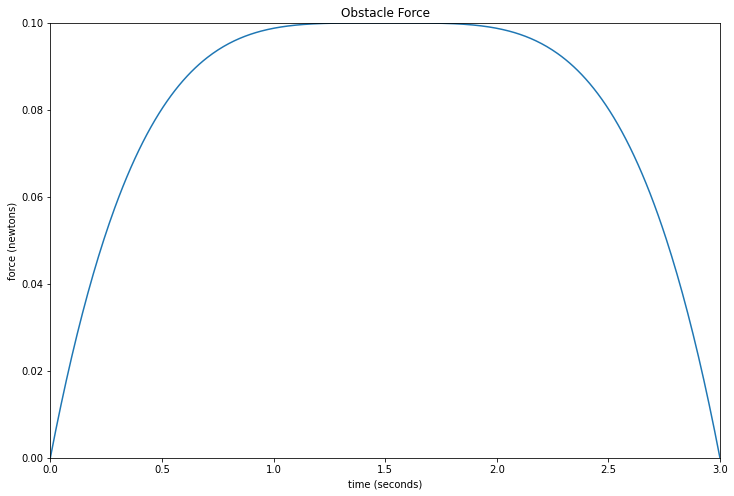

In [50]:
o = Obstacle(amp=0.1, wvl=3, loc=0, shape=0).plot_force()